#### Contents

0. [Load data and preprocess](#Load-data-and-preprocess)
1. [Initialize VRAE object](#Initialize-VRAE-object)
2. [Fit the model onto dataset](#Fit-the-model-onto-dataset)
3. [Transform the input timeseries to encoded latent vectors](#Transform-the-input-timeseries-to-encoded-latent-vectors)
4. [Save the model to be fetched later](#Save-the-model-to-be-fetched-later)

### Import required modules

In [1]:
from model.vrae import VRAE

from model.utils import *
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import trange
import tqdm

import pickle

from sklearn.preprocessing import MinMaxScaler


### Input parameters

In [2]:
dload = './saved_model' #download directory

### utils.load_data

In [3]:
def load_gen_data(file_name, cols_to_remove = None):
    """
    folder: folder where data is located
    """
    
    # define path(must be in pkl file)
    data_loc = f'./data/netis/{file_name}.pkl'    
    
    # get data
    with open(data_loc, 'rb') as f:
        df = pickle.load(f)
    
    # if needed remove columns that is not necessary
    if cols_to_remove != None:
        df = df_total.drop(cols_to_remove, axis=1)
    
    df = df.dropna()
    
    # TRAIN TEST SPLIT
    # TRAIN
    TRAIN_DF = df.query('Time < 20211103184400 or Time > 20211106084400 and label==0')
    
    # TEST(GET ONLY 정상)
    TEST_DF = df.query('Time >= 20211103184400 and Time <= 20211106084400 and label==0')

    TOTAL_DF = df.to_numpy()
    
    # REMOVE TIME & LABEL
    TRAIN_DF = TRAIN_DF.iloc[:,1:-1].to_numpy()
    TEST_DF = TEST_DF.iloc[:,1:-1].to_numpy()
    
    MM_scaler = MinMaxScaler()
    
    TRAIN_SCALED = MM_scaler.fit(TRAIN_DF).transform(TRAIN_DF)
    TEST_SCALED = MM_scaler.transform(TEST_DF)
    
    return TOTAL_DF, TRAIN_DF, TEST_DF, TRAIN_SCALED, TEST_SCALED, MM_scaler

### Hyper parameters

### Load data and preprocess
- `file_name` : pkl file_name
- `cols_to_remove` : generation 수행하지 않을 column 제거

In [4]:
# params
file_name = 'netis'

# load data
TOTAL_DF, TRAIN_DF, TEST_DF, TRAIN_SCALED, TEST_SCALED, MM_scaler = load_gen_data(file_name)

# shape
print(TOTAL_DF.shape)
print(TRAIN_SCALED.shape)
print(TEST_SCALED.shape)

(26002, 94)
(22363, 92)
(3627, 92)


In [5]:
TRAIN_SCALED

array([[3.66328864e-04, 2.52639355e-05, 2.90615333e-05, ...,
        3.42446043e-01, 4.98597475e-01, 1.65289256e-01],
       [2.66795942e-04, 3.25753827e-05, 3.13032504e-05, ...,
        3.51079137e-01, 4.97896213e-01, 1.65289256e-01],
       [2.01613776e-04, 1.37864421e-05, 3.04728091e-05, ...,
        3.51079137e-01, 4.97896213e-01, 1.23966942e-01],
       ...,
       [2.66813941e-03, 9.48559406e-04, 3.24553957e-06, ...,
        6.04316547e-01, 9.89481066e-01, 2.89256198e-01],
       [1.45200665e-03, 2.26151271e-03, 3.08280452e-06, ...,
        6.04316547e-01, 9.88779804e-01, 3.05785124e-01],
       [8.30917887e-03, 8.96945321e-04, 7.79900694e-06, ...,
        6.04316547e-01, 9.88779804e-01, 2.97520661e-01]])

In [6]:
TEST_SCALED

array([[4.02355635e-03, 6.62881732e-05, 1.69243372e-05, ...,
        6.79136691e-01, 3.52033661e-01, 2.14876033e-01],
       [4.07135202e-03, 1.18662977e-04, 6.92800865e-06, ...,
        6.79136691e-01, 3.52734923e-01, 2.14876033e-01],
       [4.02378633e-03, 2.82489361e-04, 2.07942738e-05, ...,
        6.79136691e-01, 3.52734923e-01, 2.14876033e-01],
       ...,
       [3.98419630e-03, 7.85747554e-05, 1.75819403e-05, ...,
        5.98561151e-01, 4.25666199e-01, 2.56198347e-01],
       [3.98799304e-03, 4.90275879e-05, 3.81572787e-06, ...,
        6.00000000e-01, 4.24964937e-01, 2.56198347e-01],
       [3.93781591e-03, 3.97621553e-05, 8.13602856e-06, ...,
        6.04316547e-01, 4.24964937e-01, 2.47933884e-01]])

In [7]:
class GenerationDataset(Dataset):
    def __init__(self, data, window):
        self.data = torch.Tensor(data)
        self.window = window
 
    def __len__(self):
        return len(self.data) // self.window # -1
    
    def __getitem__(self, index):
#         x = self.data[index*self.window:index*(self.window+1)]
        x = self.data[index*self.window:(index+1)*(self.window)]
        return x

In [8]:
window = 100

In [9]:
train_dataset = GenerationDataset(TRAIN_SCALED, window)
train_dataset

In [10]:
test_dataset = GenerationDataset(TEST_SCALED, window)
test_dataset

In [11]:
train_dataset[0].shape

torch.Size([100, 92])

**Fetch `sequence_length` from dataset**

In [12]:
sequence_length = train_dataset[0].shape[0]
sequence_length

100

**Fetch `number_of_features` from dataset**

This config corresponds to number of input features

In [13]:
number_of_features = train_dataset[0].shape[1]
number_of_features

92

### Parameters

In [14]:
n_epochs = 1000
hidden_size = 90
hidden_layer_depth = 1
latent_length = 20
batch_size = 1
learning_rate = 0.0005
dropout_rate = 0.2
optimizer = 'Adam' # options: ADAM, SGD
cuda = True # options: True, False
print_every=30
clip = True # options: True, False
max_grad_norm=5
loss = 'MSELoss' # options: SmoothL1Loss, MSELoss
block = 'LSTM' # options: LSTM, GRU

### Initialize VRAE object

VRAE inherits from `sklearn.base.BaseEstimator` and overrides `fit`, `transform` and `fit_transform` functions, similar to sklearn modules

In [15]:
vrae = VRAE(sequence_length=sequence_length,
            number_of_features = number_of_features,
            hidden_size = hidden_size, 
            hidden_layer_depth = hidden_layer_depth,
            latent_length = latent_length,
            batch_size = batch_size,
            learning_rate = learning_rate,
            n_epochs = n_epochs,
            dropout_rate = dropout_rate,
            optimizer = optimizer, 
            cuda = cuda,
            print_every=print_every, 
            clip=clip, 
            max_grad_norm=max_grad_norm,
            loss = loss,
            block = block,
            dload = dload)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


### Fit the model onto dataset

In [16]:
loss_arr = vrae.fit(train_dataset)

#If the model has to be saved, with the learnt parameters use:
# vrae.fit(dataset, save = True)

Epoch: 0
Batch 30, loss = 20.1691, recon_loss = 20.1585, kl_loss = 0.0105
Batch 60, loss = 1.1308, recon_loss = 0.9764, kl_loss = 0.1543
Batch 90, loss = 1.4159, recon_loss = 1.1985, kl_loss = 0.2174
Batch 120, loss = 0.9853, recon_loss = 0.8492, kl_loss = 0.1361
Batch 150, loss = 104.0810, recon_loss = 103.7934, kl_loss = 0.2875
Batch 180, loss = 34.8238, recon_loss = 34.5251, kl_loss = 0.2987
Batch 210, loss = 145.7853, recon_loss = 145.6248, kl_loss = 0.1605
Average loss: 40.0274
Epoch: 1
Batch 30, loss = 18.4178, recon_loss = 18.3372, kl_loss = 0.0806
Batch 60, loss = 0.9833, recon_loss = 0.8878, kl_loss = 0.0955
Batch 90, loss = 1.1759, recon_loss = 1.0854, kl_loss = 0.0906
Batch 120, loss = 0.6553, recon_loss = 0.5694, kl_loss = 0.0859
Batch 150, loss = 121.4154, recon_loss = 121.1637, kl_loss = 0.2518
Batch 180, loss = 44.9991, recon_loss = 44.7725, kl_loss = 0.2266
Batch 210, loss = 102.8021, recon_loss = 102.7156, kl_loss = 0.0866
Average loss: 43.0925
Epoch: 2
Batch 30, loss 

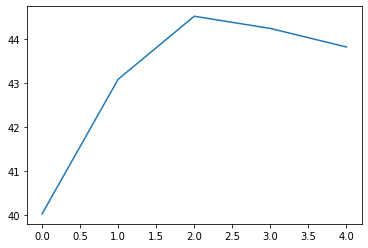

In [17]:
import matplotlib.pyplot as plt

plt.plot(loss_arr)

### Save the model to be fetched later

In [18]:
vrae.save('vrae.pth')

# To load a presaved model, execute:
# vrae.load('vrae.pth')

In [19]:
vrae.is_fitted

True

### Transform the input timeseries to encoded latent vectors

In [20]:
z_run = vrae.transform(test_dataset)
z_run

array([[-0.3283009 , -0.07758239, -0.39262283,  0.6337836 , -0.14250779,
        -0.42093807,  1.4153192 ,  0.27768546, -0.1267438 , -0.9205529 ,
        -0.15797167, -0.41524243, -0.03784581, -0.25592178,  0.83391577,
         0.04710793, -0.31536686,  0.5249646 ,  0.21208462,  0.2258121 ],
       [-0.32932857, -0.07571401, -0.38458776,  0.6371127 , -0.14501224,
        -0.42259476,  1.4171376 ,  0.27288717, -0.12295309, -0.922328  ,
        -0.16112496, -0.41532454, -0.03310846, -0.2561079 ,  0.83122796,
         0.05048269, -0.31407908,  0.52527285,  0.20657781,  0.22409223],
       [-0.3293326 , -0.07919408, -0.39396378,  0.63517714, -0.14457206,
        -0.42058274,  1.4203824 ,  0.27850318, -0.1282128 , -0.9255527 ,
        -0.16013956, -0.4163918 , -0.0392042 , -0.25665912,  0.83366126,
         0.04842175, -0.31540272,  0.5269687 ,  0.21376064,  0.22812812],
       [-0.32741308, -0.07652487, -0.39832154,  0.6342776 , -0.1428913 ,
        -0.42046955,  1.4156059 ,  0.27616864, -

In [21]:
z_run.shape

(36, 20)

In [22]:
from einops import rearrange
import torch.nn as nn

In [23]:
def concat_recon(recon_output):
    w,b,f = recon_output.shape
    
    tmp = rearrange(recon_output, 'w b f -> b w f')

    output = tmp.reshape(w*b,f)

    return output

def inverse_minmax(x):
    inv_x = MM_scaler.inverse_transform(x)
    return inv_x

def eval_recon(recon, real):
    criterion = nn.MSELoss()
    
    # undo minmax scaling
    recon = inverse_minmax(recon)
    r = recon.shape[0]
    real = real[:r,:]
    
    # get shape
    print(recon.shape)
    print(real.shape)

    # compute loss
    loss = criterion(torch.tensor(recon), torch.tensor(real))
    
    return loss

## Reconstruct

### Train

In [24]:
# train reconstruct
train_recon = vrae.reconstruct(train_dataset)
print(train_recon.shape)
train_recon

(100, 223, 92)


array([[[-4.8782602e-03,  3.2337829e-03, -1.6913610e-03, ...,
          6.2147075e-01,  7.0292068e-01,  2.8031370e-01],
        [-4.9236380e-03,  3.2461509e-03, -1.6001025e-03, ...,
          6.2206912e-01,  7.0298964e-01,  2.8042886e-01],
        [-4.9354248e-03,  3.2331198e-03, -1.6145194e-03, ...,
          6.2230664e-01,  7.0309055e-01,  2.8042564e-01],
        ...,
        [-3.4472227e-02, -9.5225573e-03,  5.7191784e-03, ...,
          7.4569672e-01,  7.9110867e-01,  3.2892352e-01],
        [-3.5389028e-02, -1.0033652e-02,  6.0556410e-03, ...,
          7.4901038e-01,  7.9370308e-01,  3.3004621e-01],
        [-8.1553161e-03,  2.2513270e-03, -1.4175484e-03, ...,
          6.4012724e-01,  7.1545595e-01,  2.8653452e-01]],

       [[-1.6567037e-03,  2.6503503e-03,  1.9139936e-03, ...,
          6.8743038e-01,  7.4862444e-01,  3.0775353e-01],
        [-1.6512312e-03,  2.6184767e-03,  2.0051887e-03, ...,
          6.8779141e-01,  7.4888068e-01,  3.0789512e-01],
        [-1.6503185e-03, 

In [25]:
train_recon = concat_recon(train_recon)
train_recon.shape

(22300, 92)

In [26]:
train_recon.shape[0]

22300

In [27]:
TRAIN_DF.shape

(22363, 92)

In [28]:
TRAIN_DF[:22300,:].shape

(22300, 92)

In [29]:
eval_recon(train_recon, TRAIN_DF)

(22300, 92)
22300
(22363, 92)
(22300, 92)
(22300, 92)


tensor(8.6821e+13, dtype=torch.float64)

### Test

In [30]:
# test reconstruct
test_recon = vrae.reconstruct(test_dataset)
print(test_recon.shape)
test_recon

(100, 36, 92)


array([[[-3.2022916e-02, -8.7053478e-03,  5.0663734e-03, ...,
          7.3718578e-01,  7.8325510e-01,  3.2488543e-01],
        [-3.2122895e-02, -8.6695254e-03,  5.0868271e-03, ...,
          7.3723871e-01,  7.8333461e-01,  3.2511094e-01],
        [-3.2058015e-02, -8.7839365e-03,  5.0666286e-03, ...,
          7.3749161e-01,  7.8350717e-01,  3.2499230e-01],
        ...,
        [-3.2968566e-02, -9.1041625e-03,  5.5342047e-03, ...,
          7.4000162e-01,  7.8560388e-01,  3.2622138e-01],
        [-3.2970339e-02, -9.1625080e-03,  5.5271098e-03, ...,
          7.4040800e-01,  7.8598398e-01,  3.2629061e-01],
        [-3.2929800e-02, -9.1449842e-03,  5.5504842e-03, ...,
          7.4036354e-01,  7.8596669e-01,  3.2632855e-01]],

       [[-3.9821714e-03, -9.3578100e-03,  6.2545603e-03, ...,
          7.6981050e-01,  8.4496236e-01,  3.4480545e-01],
        [-3.9937682e-03, -9.3560144e-03,  6.2569072e-03, ...,
          7.6968658e-01,  8.4490842e-01,  3.4482506e-01],
        [-3.9908513e-03, 

In [31]:
test_recon = concat_recon(test_recon)
test_recon.shape

(3600, 92)

In [32]:
eval_recon(test_recon, TEST_DF)

(3600, 92)
3600
(3627, 92)
(3600, 92)
(3600, 92)


tensor(2.1009e+13, dtype=torch.float64)